In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split

import tensorflow as tf
from keras.utils.np_utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt

In [2]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

In [3]:
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
y_train = train['label']
X_train = train.drop(columns=['label']).copy()

In [5]:
print(X_train.shape)
print(test.shape)
print('-'*30)
print(sum(X_train.isnull().sum()))
print('-'*30)
print(set(X_train.loc[0]))
print('-'*30)
print(set(y_train))

(42000, 784)
(28000, 784)
------------------------------
0
------------------------------
{0, 131, 7, 10, 13, 15, 16, 17, 20, 22, 23, 25, 27, 29, 159, 167, 168, 170, 54, 188, 191, 195, 196, 198, 203, 76, 77, 206, 207, 80, 208, 209, 210, 81, 214, 88, 89, 218, 220, 93, 94, 95, 103, 235, 238, 251, 240, 245, 247, 248, 250, 123, 253, 254, 255}
------------------------------
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}


/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


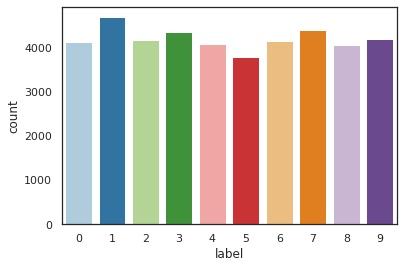

In [6]:
sns.set(style='white', context='notebook', palette='Paired')
g = sns.countplot(y_train)

In [7]:
X_train /= 255
test /= 255

In [8]:
X_train = X_train.values.reshape(-1, 28, 28, 1)
test = test.values.reshape(-1, 28, 28, 1)

In [9]:
y_train = to_categorical(y_train, num_classes = 10)

In [10]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, 
                                            test_size=0.2, random_state=0)

In [11]:
# data augmentation

dataGen = ImageDataGenerator(
        featurewise_center=False,
        samplewise_center=False,
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,
        zca_whitening=False,
        rotation_range=20,
        zoom_range = 0.1,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=False,
        vertical_flip=False)

dataGen.fit(X_train)

# Model

In [12]:
model = Sequential()

model.add(Conv2D(filters = 128, kernel_size = (3, 3),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1)))
model.add(Conv2D(filters = 128, kernel_size = (3, 3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters = 64, kernel_size = (3, 3),padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3, 3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters = 32, kernel_size = (3, 3),padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 32, kernel_size = (3, 3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dropout(0.5))

model.add(Dense(32, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(16, activation = "relu"))
model.add(Dense(10, activation = "softmax"))

2023-01-23 09:04:26.157342: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 128)       1280      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 128)       147584    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 64)        73792     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 7, 7, 32)          1

In [14]:
model.compile(loss='categorical_crossentropy', 
              metrics=["accuracy"],
              optimizer=Adam(learning_rate=0.0003))

epochs = 20
BS = 64

history = model.fit(dataGen.flow(X_train,y_train, batch_size = BS),
                    epochs= epochs,
                    validation_data=(X_valid, y_valid),
                    verbose = 1)

2023-01-23 09:04:26.579747: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20
525/525 [==============================] - 315s 597ms/step - loss: 1.8646 - accuracy: 0.3094 - val_loss: 0.7530 - val_accuracy: 0.8011
Epoch 2/20
525/525 [==============================] - 295s 562ms/step - loss: 1.0532 - accuracy: 0.6365 - val_loss: 0.2673 - val_accuracy: 0.9337
Epoch 3/20
525/525 [==============================] - 294s 561ms/step - loss: 0.7063 - accuracy: 0.7759 - val_loss: 0.1615 - val_accuracy: 0.9574
Epoch 4/20
525/525 [==============================] - 293s 559ms/step - loss: 0.5258 - accuracy: 0.8368 - val_loss: 0.1290 - val_accuracy: 0.9642
Epoch 5/20
525/525 [==============================] - 289s 551ms/step - loss: 0.4475 - accuracy: 0.8659 - val_loss: 0.0922 - val_accuracy: 0.9756
Epoch 6/20
525/525 [==============================] - 286s 545ms/step - loss: 0.3839 - accuracy: 0.8853 - val_loss: 0.0775 - val_accuracy: 0.9800
Epoch 7/20
525/525 [==============================] - 288s 548ms/step - loss: 0.3351 - accuracy: 0.9002 - val_loss: 0.1088 -

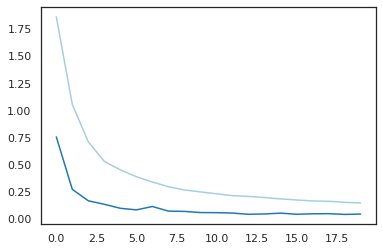

In [15]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

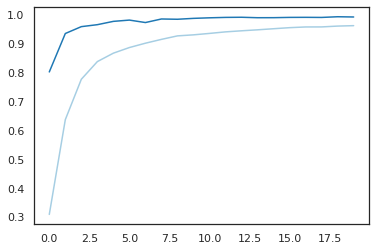

In [16]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.show()

In [17]:
# predict
y_pred = model.predict(X_valid)
y_classes = np.argmax(y_pred,axis = 1) 

# acc
y_true = np.argmax(y_valid,axis = 1) 

In [18]:
confusion_mtx = confusion_matrix(y_true, y_classes) 
confusion_mtx

array([[805,   0,   1,   0,   0,   0,   4,   0,   2,   1],
       [  0, 948,   3,   1,   0,   1,   3,   3,   2,   0],
       [  1,   0, 856,   0,   0,   0,   1,   0,   2,   0],
       [  1,   0,   3, 853,   0,   3,   0,   2,   0,   1],
       [  0,   2,   0,   0, 821,   0,   2,   0,   0,   2],
       [  0,   0,   0,   0,   0, 751,   2,   0,   2,   1],
       [  0,   0,   0,   0,   0,   0, 839,   0,   2,   0],
       [  0,   1,  10,   0,   0,   0,   0, 883,   0,   5],
       [  0,   0,   0,   0,   0,   0,   1,   0, 767,   0],
       [  0,   0,   0,   0,   4,   1,   0,   1,   7, 799]])

Text(0.5, 28.479184719828694, 'Predicted label')

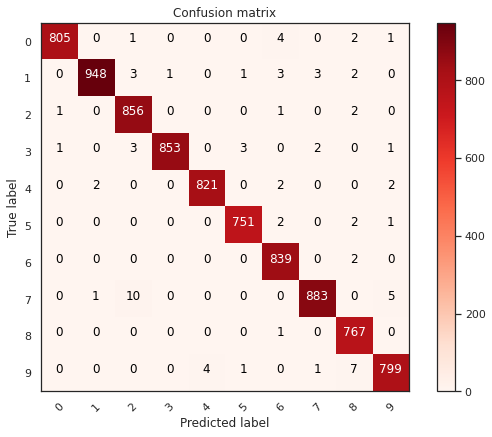

In [19]:
classes = range(10)

plt.figure(figsize=(8, 6))
plt.imshow(confusion_mtx, interpolation='nearest', cmap = plt.cm.Reds)
plt.title('Confusion matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

thresh = confusion_mtx.max() / 2.
for i, j in itertools.product(range(confusion_mtx.shape[0]), range(confusion_mtx.shape[1])):
    plt.text(j, i, confusion_mtx[i, j],
             horizontalalignment="center",
             color="white" if confusion_mtx[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [20]:
results = model.predict(test)
results_classes = np.argmax(results, axis = 1)

In [21]:
submission = pd.DataFrame({
    'ImageId': np.arange(1,len(test)+1),
    'Label': results_classes
})

In [22]:
submission.to_csv("submission.csv",index=False)